# The data

https://archive-beta.ics.uci.edu/ml/datasets/105

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

import plotly.graph_objects as go

## Exploratory Analysis

The house-votes-84.names file contains the feature column names as well as important information about the data, including what missing values represent. Below we see that the data includes 435 members (samples) of Congress who voted on 16 key measures (features). Each voting member of Congress is either a Democrat or Republican. The data is heavily skewed in favor of the democrat class with 267 voting members compared to the 168 republicans. An important detail pointed out in the document is that a missing value denoted by "?" does not mean the attribute is unknown, but rather that the value is not a "yay" or "nay". 

In [2]:
lines = 80

with open('house-votes-84.names', 'r') as f:
    for _ in range(lines):
        line = f.readline()
        print(line.strip())

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
(a) Source:  Congressional Quarterly Almanac, 98th Congress,
2nd session 1984, Volume XL: Congressional Quarterly Inc.
Washington, D.C., 1985.
(b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
(c) Date: 27 April 1987

3. Past Usage
- Publications
1. Schlimmer, J. C. (1987).  Concept acquisition through
representational adjustment.  Doctoral dissertation, Department of
Information and Computer Science, University of California, Irvine, CA.
-- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
- Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
This data set includes votes for each of the U.S. House of
Representatives Congressmen on the 16 key votes identified by the
CQA.  The CQA lists nine different types of votes: voted for, paired
for, and announced for (these three simplified to yea), voted
against, paired against, and announced against (th

In [3]:
# make a list of the column names from the document above
cols = ['party', 'handicapped-infants', 'water-project-cost-sharing', 'adoption-of-the-budget-resolution', 'physician-fee-freeze', 
       'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-corporation-cutback', 'education-spending', 'superfund-right-to-sue', 'crime', 'duty-free-exports', 
        'export-administration-act-south-africa']

# pass data with column names into a pandas dataframe
data = pd.read_csv('house-votes-84.data', names=cols)
data.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


A sample of the data is shown above. Each row represents one congress member's votes on the 16 key measures. Possible values are n for nay, y for yay, and ? for a missing value.

Number of Instances: 435 (267 democrats, 168 republicans)

To start exploring the data visually, I'm going to write a convenient plotting function.

In [50]:
def plot_bar(measure=None):
    """
    Plot a bar chart of the vote distribution for a single or multiple measures (if passed as a string).
    If None (default), plot a bar chart for all measures.
    
    Parameters
    ----------
    measure : list or string, optional
        The measure(s) to plot bar charts for.
    """
    # possible vote values
    x=['?', 'nay', 'yay']
    
    # if a measure(s) name is passed, plot one bar chart for each measure
    if measure != None:
        if type(measure) is str:
            if measure not in data.columns:
                raise ValueError('measure not found')
            else:
                # count number of votes for each category by party
                y_dems=data[data.party=='democrat'][measure].value_counts()
                y_reps=data[data.party=='republican'][measure].value_counts()

                # plot the results in a bar chart
                fig = go.Figure(data=[
                    go.Bar(name='democrat', x=x, y=y_dems.sort_index(), marker_color='#2F74FE'),
                    go.Bar(name='republican', x=x, y=y_reps.sort_index(), marker_color='#FF5439')
                ])

                fig.update_layout(
                    title=measure,
                    template='ggplot2',
                    xaxis_title="Vote",
                    yaxis_title="Count",
                    font=dict(size=18),
                    barmode='group'
                )

                fig.show()
                
        elif type(measure) is list:
            for m in measure:
                if m not in data.columns:
                    raise ValueError('measure not found')
                else:
                    # count number of votes for each category by party
                    y_dems=data[data.party=='democrat'][m].value_counts()
                    y_reps=data[data.party=='republican'][m].value_counts()

                    # plot the results in a bar chart
                    fig = go.Figure(data=[
                        go.Bar(name='democrat', x=x, y=y_dems.sort_index(), marker_color='#2F74FE'),
                        go.Bar(name='republican', x=x, y=y_reps.sort_index(), marker_color='#FF5439')
                    ])

                    fig.update_layout(
                        title=m,
                        template='ggplot2',
                        xaxis_title="Vote",
                        yaxis_title="Count",
                        font=dict(size=18),
                        barmode='group'
                    )

                    fig.show()
        # if measure is not passed a string or list, raise a ValueError
        else:
            raise ValueError('measure must be a string or list of strings')
        
    else:

        # for each ballot measure
        for col in data.iloc[:,1:]:

            # count number of votes for each category by party
            y_dems=data[data.party=='democrat'][col].value_counts()
            y_reps=data[data.party=='republican'][col].value_counts()

            # plot the results in a bar chart
            fig = go.Figure(data=[
                go.Bar(name='democrat', x=x, y=y_dems.sort_index(), marker_color='#2F74FE'),
                go.Bar(name='republican', x=x, y=y_reps.sort_index(), marker_color='#FF5439')
            ])

            fig.update_layout(
                title=col,
                template='ggplot2',
                xaxis_title="Vote",
                yaxis_title="Count",
                font=dict(size=18),
                barmode='group'
            )

            fig.show()

After exploring some of the features graphically, I want to focus and divde a little deeper on some of them. Take the "adoption-of-the-budget-resolution" shown below, this measure shows a large disparity in support between the two parties. Deomocrats are overwhelmingly for the measure while republicans are overwhelmingly against. 

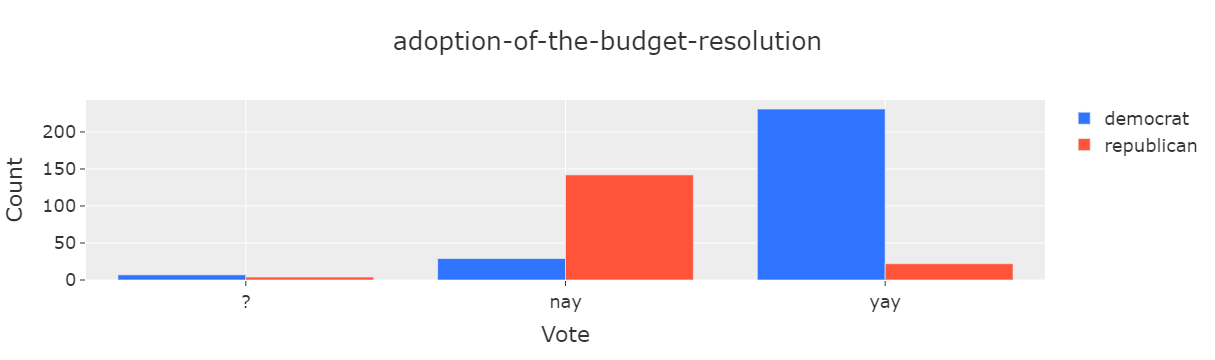

In [51]:
plot_bar('adoption-of-the-budget-resolution')

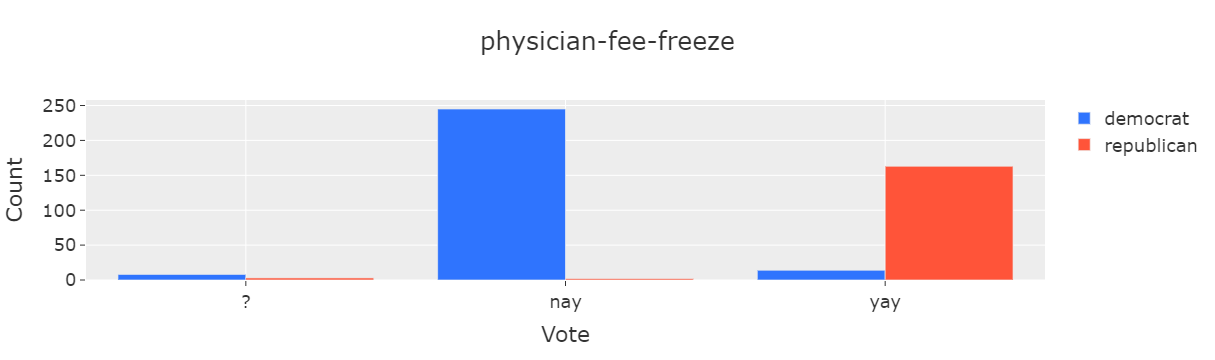

In [52]:
plot_bar('physician-fee-freeze')

The "physican-fee-freeze" measure shows the opposite, with democrats heavily voting against and republicans mostly voting for the measure.

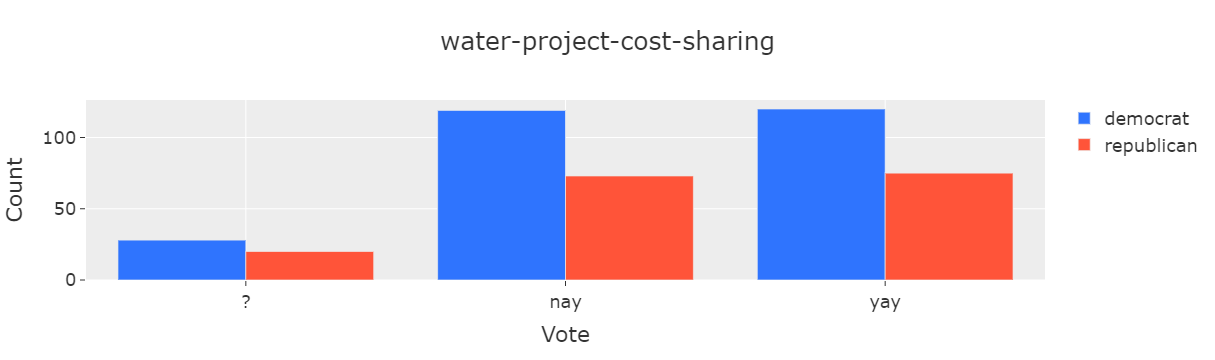

In [53]:
plot_bar('water-project-cost-sharing')

"water-project-cost-sharing" is an example where both parties were split in their support without about 50% in favor and 50% against in both parties.

To summarize these results, we're going to calculate the % of yes votes for each party and for each measure. This will give us a metric for the overal support of each party for each measure. We will use this as one method of imputation for missing values in the dataset.

In [8]:
d_ratings = []
r_ratings = []
for col in data.iloc[:,1:]:
    counts = data[['party',col]].groupby(['party',col]).size()
    
    d_ratings.append(round(counts.loc['democrat','y']/counts.loc['democrat',['n','y']].sum(), 3))
    r_ratings.append(round(counts.loc['republican','y']/counts.loc['republican',['n','y']].sum(), 3))
    
perc_yes = pd.DataFrame.from_dict({'democrat':d_ratings, 'republican':r_ratings}, orient='index', columns=cols[1:])

In [9]:
perc_yes

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
democrat,0.605,0.502,0.888,0.054,0.216,0.477,0.772,0.829,0.758,0.471,0.506,0.145,0.290,0.350,0.637,0.935
republican,0.188,0.507,0.134,0.988,0.952,0.898,0.241,0.153,0.115,0.558,0.132,0.871,0.861,0.981,0.090,0.658


## Data Munging

In [10]:
# separate X training data and y labels
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [11]:
X.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


Votes are counted as either y (yes) or n (no). These can be one-hot encoded to 1 and 0 respectively. However, there are also ? values which represent not unknown values but simply not a yes or no as described in the dataset description.

In [12]:
# count the number of missing values, "?"
missing_count = (X=="?").sum().sum()

print(f'There are {missing_count} missing or ? values in the whole dataset.')

There are 392 missing or ? values in the whole dataset.


In [13]:
# calculate the percentage of ? values in the data
df_size = X.shape[0]*X.shape[1]

print(f'This corresponds to {round(missing_count/df_size * 100, 2)}% of the total data.')

This corresponds to 5.63% of the total data.


Let's count the number of ? values per row to see what the highest number of missing values is for any given Congress person.

In [14]:
(X=='?').sum(axis=1).sort_values(ascending=False)[:10]

248    16
183    15
107    14
129     9
377     7
261     6
295     6
104     6
180     6
400     5
dtype: int64

Above are the top 10 samples with missing values. There is one Congress person for which all data is missing. I'm curious for imputation reasons whether either party has a larger number of missing values or if the missing values are practically evenly split between parties.

In [15]:
# subset data by party into individual dataframes
dems = data[data.party=='democrat']
reps = data[data.party=='republican']

# compute % of missing values by party
missing_dems = (dems=="?").sum().sum()/dems.size*100
missing_reps = (reps=="?").sum().sum()/reps.size*100

print(f'% missing Democrats: {round(missing_dems, 2)}%')
print(f'% missing Replicans: {round(missing_reps, 2)}%')

% missing Democrats: 5.75%
% missing Replicans: 4.59%


So the number of missing values by party is roughly equivalent with the democrats having 1.16% higher missing values than republicans.

### A note on imputation

In [16]:
print(f'The # of samples with at least one missing value is {(data=="?").any(axis=1).sum()}.')

The # of samples with at least one missing value is 203.


SKlearn's KNN classifier requires data to be complete with no missing values. This is so that samples can be compared equally against each other with the same size vector describing them. Our data contains 5.63% of missing values. These missing values are spread across 203 samples. If I were to simply delete these samples list-wise, I would have to discard 203 out of a total 435 samples which is very nearly half the data! Since this is not a resonable method to deal with missing values in this dataset, we will resolve to trying different imputation methods.

I will compare the performance of the KNN classifier using various methods for imputing the missing values in our dataset. It's therefore worth noting the following. First, imputation is typically invoked to infer a value that is unknown to us. It assumes there is some ground truth value which we do not have but we are making our best guess at what it is. In this case however, we do know the value which is simply neither yay or nay. As described in the "names" file, 

> voted present, voted present to avoid conflict
of interest, and did not vote or otherwise make a position known
(these three simplified to an unknown disposition)

What we are really doing by imputing then is saying if this voter was required to simply vote yay or nay, and they had no other option, which way would they vote?

The second important point is that because of the slightly higher percentage (1.16%) of missing values for democrats, there may be a slightly higher imputation error rate for this class, when compared to repbulicans.

In [17]:
# replace ? values with NaN
X = X.replace({'n':0, 'y':1, '?':np.nan})

In [18]:
X.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [19]:
# split train and test data with stratification and a 33% test sample size
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

The dataset is first split into training (X_train, y_train) and testing sets (y_train, y_test) before the various imputations are performed. The split was stratified on party since there is a skew in this class.

In [20]:
print(f"Ratio of democrats to republicans in test data: {round(y_test.value_counts()[0]/y_test.value_counts()[1], 2)}")

Ratio of democrats to republicans in test data: 1.57


In [21]:
print(f"Ratio of democrats to republicans in train data: {round(y_train.value_counts()[0]/y_train.value_counts()[1], 2)}")

Ratio of democrats to republicans in train data: 1.6


## Model Analysis

### KNN with 0.5 Imputation

The first method of imputation I'd like to implement is simply replacing all missing values with the value 0.5. 0.5 is equidistant to the values 0 and 1 and therefore is equally similar/dissimilar to both a yay and nay. But using a constant has the added benefit that 0.5 values will be exactly equal to other missing values since they will all have a value of 0.5. This may provide additional predictive power if there is a similarity between how missing values arise in democrats vs republicans.

In [22]:
# replace NaN values with 0.5
X_train_half_imp = X_train.fillna('0.5')
X_test_half_imp = X_test.fillna('0.5')

In [23]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train_half_imp, y_train)

# predict the response
y_pred = knn.predict(X_test_half_imp)

# evaluate accuracy
print(f"Accuracy: {format(round(accuracy_score(y_test, y_pred)*100, 2))}%")

Accuracy: 94.44%


The accuracy achieved by replacing all missing values with 0.5 is 94.44%. Below is a table of all of the misclassifications on the test set. There are a total of 8 misclassified samples out of the 144 samples in the test set. Interestinly, there is only a single missing value in all of these samples.

In [24]:
# get all misclassified samples
misclassified = data.loc[y_test.index[y_test != y_pred], :]
misclassified

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
147,democrat,n,n,n,n,n,n,y,y,y,y,n,y,y,y,y,y
375,democrat,n,y,n,y,y,y,n,n,n,n,y,y,n,y,n,n
407,democrat,n,n,n,y,y,y,n,n,n,n,y,y,y,y,n,n
73,republican,y,n,y,y,y,n,y,n,y,y,n,n,y,y,n,y
397,democrat,y,y,n,n,y,?,n,n,n,n,y,n,y,y,n,y
363,republican,y,y,n,y,y,y,n,n,n,y,y,n,y,n,n,n
167,republican,y,n,y,y,y,y,y,y,n,y,y,y,n,y,y,y
77,democrat,n,y,y,y,y,y,n,y,y,y,y,y,y,y,n,y


Below are the top 8 samples in the test set with the most missing values. 4 missing values corresponds to 25% of the sample vector. It's interesting that all of these vectors with at least 25% missing values are more accurately classified than the above 8 samples which are almost entirely free of missing values. **We can conclude then that the number of missing values is not correlated to misclassification.**

In [25]:
# get the top 10 samples with the most missing values in the test set
X_test.isnull().sum(axis=1).sort_values(ascending=False).head(8)

377    7
261    6
295    6
180    6
400    5
95     5
341    4
130    4
dtype: int64

In the data munging section, we computed the % of yays for each party across all 16 measures (shown again below). We can use the % yays value to get the "typical" democrat and republican voting cards using a majority rule. If a measure received a majority vote of greater than 50% of votes for the party, the vote will correspond to a yay, otherwise a nay. 

In [26]:
perc_yes

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
democrat,0.605,0.502,0.888,0.054,0.216,0.477,0.772,0.829,0.758,0.471,0.506,0.145,0.290,0.350,0.637,0.935
republican,0.188,0.507,0.134,0.988,0.952,0.898,0.241,0.153,0.115,0.558,0.132,0.871,0.861,0.981,0.090,0.658


In [27]:
# If % yes values are over 0.5, vote is y, otherwise vote is n
typical_vote = (perc_yes > 0.5).replace({True: 'y', False: 'n'})

# separate typical vote card for each party
typical_vote_dem = typical_vote.loc['democrat',:]
typical_vote_rep = typical_vote.loc['republican',:]

typical_vote

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
democrat,y,y,y,n,n,n,y,y,y,n,y,n,n,n,y,y
republican,n,y,n,y,y,y,n,n,n,y,n,y,y,y,n,y


The typical voting cards (based on majority voting) are shown above for both parties.

Next, I want to focus only on the ballot measures that were "divisive" to simplify the analysis. Each ballot measure is determined to be divisive if it meets the two criteria:

    1. There is a difference in the % yes votes between parties of at least 50%.
    2. There is at least one party with a % yes of 75% or higher. 
    
These two criteria return only measures that were divisive (large difference in % yes between parties) and also where at least one party was overwhelmingly in favor (% yes of 75% or higher) of the measure. The result is the subset of the perc_yes table shown below. These key measures should be strong predictors of the two classes for obvious reasons. Namely, there is a high percentage of one class voting yay compared to a very small percentage of the other class voting yay, so there's less overlap between the two party classes.

In [28]:
# only measures that had at least one party with a % yes vote of at least 75%
# and where the difference between the % yes votes was at least 50% between parties
divisive_criteria = (abs(perc_yes.loc['democrat'] - perc_yes.loc['republican']) > 0.5) & (perc_yes >= 0.75).any()
divisive_cols = divisive_criteria.index[divisive_criteria].to_list()

# subset the typical voting card to measures that are divisive
typical_vote_divisive = typical_vote[divisive_cols]
typical_vote_divisive

,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,education-spending,superfund-right-to-sue,crime
democrat,y,n,n,y,y,y,n,n,n
republican,n,y,y,n,n,n,y,y,y


Applying the divisive criteria to the full typical voting card gives us the subset shown above. Of course, because of how we defined "divisive measures", votes for each measure have opposite values between parties.

In [29]:
# get all misclassified samples
misclassified_divisive = misclassified[['party'] + divisive_cols]
misclassified_divisive

,party,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,education-spending,superfund-right-to-sue,crime
147,democrat,n,n,n,y,y,y,y,y,y
375,democrat,n,y,y,n,n,n,y,n,y
407,democrat,n,y,y,n,n,n,y,y,y
73,republican,y,y,y,y,n,y,n,y,y
397,democrat,n,n,y,n,n,n,n,y,y
363,republican,n,y,y,n,n,n,n,y,n
167,republican,y,y,y,y,y,n,y,n,y
77,democrat,y,y,y,n,y,y,y,y,y


Now we can compare the misclassified test samples to the "typical" voting card. For the first measure, *adoption-of-the-budget-resolution*, the typical democrat vote was y and the typical republican vote was n. However, we can see that **4 out of the 5 misclassified democrats voted against the party majority**. Similarly, **2 out of the 3 misclassified republicans voted against the party majority.** The party majority is defined as the value that received greater than 50% of the party's votes.

Now let's look at the last measure, *crime*, in the divisive voting card. The large majority of democrats voted against the bill while the large majority of republicans voted in favor of the bill. However, **all 5 misclassified democrats voted y, again going against their party majority.** On this bill, only 1 out of the 3 misclassified republicans voted against their party majority.

We can summarize this data by counting the number of times each sample voted against their party majority. To get a baseline, we'll first look at all correctly classified samples and all 16 ballot measures before focusing on divisive measures.

In [30]:
# get only the correctly classified samples and subset by party
correctly_classified = data.loc[y_test.index[y_test == y_pred]]
correctly_classified_dem = correctly_classified[correctly_classified.party == 'democrat']
correctly_classified_rep = correctly_classified[correctly_classified.party == 'republican']

In [31]:
# count the number of times the sample voted against the party majority
against_majority_dem = (correctly_classified_dem.iloc[:,1:] != typical_vote_dem)
against_majority_rep = (correctly_classified_rep.iloc[:,1:] != typical_vote_rep)

In [32]:
against_majority_dem.sum(axis=1).sort_values(ascending=False).head()

275    12
372    12
96     12
373    11
95      9
dtype: int64

In [33]:
against_majority_rep.sum(axis=1).sort_values(ascending=False).head()

281    9
377    8
274    7
413    7
242    7
dtype: int64

The two outputs above show the top 5 samples that had the highest number of votes against the party majority. These are all correctly classified samples. Surprisingly, 3 democrats (top) had 12 total votes against the party majority and were still correctly classified. The highest number of total votes against the party majority for republicans (bottom) was 9. Let's compare these numbers to the misclassified samples.

In [109]:
# get democrat and republican subsets of misclassified samples
misclassified_dem = misclassified[misclassified.party=='democrat']
misclassified_rep = misclassified[misclassified.party=='republican']

In [110]:
# count the # of times a misclassified democrat voted against the majority
mis_against_majority_dem = (misclassified_dem.iloc[:,1:] != typical_vote_dem)
mis_against_majority_dem.sum(axis=1).sort_values(ascending=False)

407    14
375    12
77     10
397     9
147     8
dtype: int64

In [111]:
# count the # of times a misclassified democrat voted against the majority
mis_against_majority_rep = (misclassified_rep.iloc[:,1:] != typical_vote_rep)
mis_against_majority_rep.sum(axis=1).sort_values(ascending=False)

167    8
73     7
363    5
dtype: int64

Again, we're looking at all 16 ballot measures here. 4 out of the 5 misclassified democrats (top) had an equal amount or less total votes against the party majority compared to the correctly classified samples. Democrat 147 in particular was misclassfied with only 8 votes against the party majority while all of the correctly classfied democrats had 9 or more votes against the party majority. This implies that it's not just the total number of votes that went against the party majority, but which ballot measures those votes were for which is important for classifying the party class correctly.

Let's now look at only the ballot measures for which we identified to be "divisive". We'll again begin by looking at just the correctly classified samples to get a baseline.

In [112]:
correctly_classified_dem_divisive = correctly_classified_dem[divisive_cols]
correctly_classified_rep_divisive = correctly_classified_rep[divisive_cols]
typical_vote_dem_divisve = typical_vote_dem[divisive_cols]
typical_vote_rep_divisve = typical_vote_rep[divisive_cols]

# count the number of times the sample voted against the party majority
against_majority_dem_divisive = (correctly_classified_dem_divisive != typical_vote_dem_divisve)
against_majority_rep_divisive = (correctly_classified_rep_divisive != typical_vote_rep_divisve)

In [113]:
against_majority_dem_divisive.sum(axis=1).sort_values(ascending=False).head()

372    8
96     8
394    7
95     7
275    6
dtype: int64

In [114]:
against_majority_rep_divisive.sum(axis=1).sort_values(ascending=False).head()

413    5
281    5
377    4
349    4
343    4
dtype: int64

The two outputs above show the top 5 samples with the highest number of votes against the party majority (top: democrat, bottom: republican). As one would expect, the total number of votes that went against the party majority is less when only looking at the divisive measures. The top 5 democrats who had the highest number of votes against the party majority had on average 2.8 more votes against the party majority than republicans did. That is to say, out of the democrats and republicans who voted against the party majority on at least one measure, the democrats tended to vote against the party majority more often than republicans.

In [115]:
mis_against_majority_dem_divisive = (misclassified_dem[divisive_cols] != typical_vote_dem_divisve)
mis_against_majority_dem_divisive.sum(axis=1).sort_values(ascending=False)

407    9
375    8
397    7
77     6
147    4
dtype: int64

In [116]:
mis_against_majority_rep_divisive = (misclassified_rep[divisive_cols] != typical_vote_rep_divisve)
mis_against_majority_rep_divisive.sum(axis=1).sort_values(ascending=False)

73     4
167    4
363    2
dtype: int64

The two outputs above show the number of votes against the party majority for divisive measures only (top: democrat, bottom: republican). Notice that the numbers are not too different from the correctly classified samples. **This implies that the total number of votes against the party majority may not be a large factor in correctly classifying the party. More important might be which measures specifically a sample voted against the party majority on.** To explore this theory, I want to look at distributions of the votes against the party majority.

In [94]:
def plot_votes(df, title='Voted Against'):
    fig = go.Figure(data = go.Bar(x=df.index, y=df, 
                                  marker=dict(color=df, colorscale='portland',
                                              cmin=0, cmax=1,
                                              reversescale=False, showscale=True)),
                   layout = dict(
                       title=dict(
                           text=title, x=0.5),
                        yaxis=dict(title='Normalized Count', range=[0,1.1])
                   )
                   )

    fig.show()

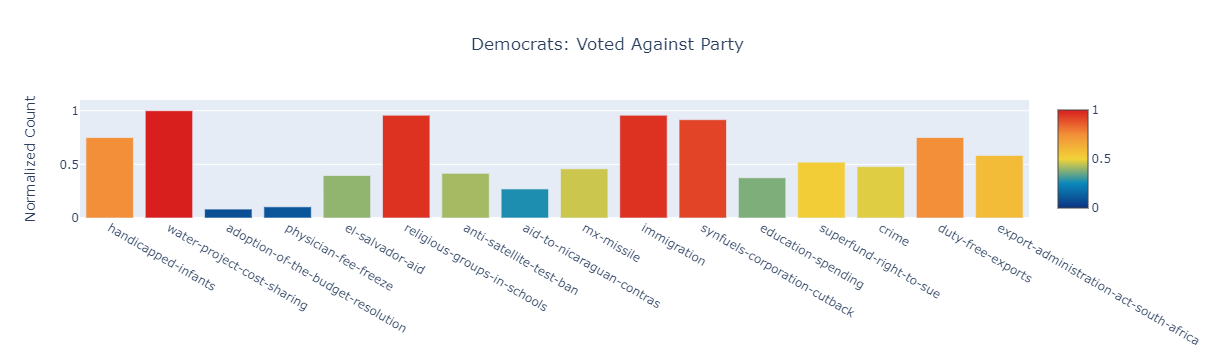

In [100]:
df1 = against_majority_dem.sum()/against_majority_dem.sum().max()

plot_votes(df=df1, title='Democrats: Voted Against Party')

In [108]:
against_majority_dem.sum()

handicapped-infants                       36
water-project-cost-sharing                48
adoption-of-the-budget-resolution          4
physician-fee-freeze                       5
el-salvador-aid                           19
religious-groups-in-schools               46
anti-satellite-test-ban                   20
aid-to-nicaraguan-contras                 13
mx-missile                                22
immigration                               46
synfuels-corporation-cutback              44
education-spending                        18
superfund-right-to-sue                    25
crime                                     23
duty-free-exports                         36
export-administration-act-south-africa    28
dtype: int64

The bar chart above shows the distribution of votes against the party majority for democrats, across all 16 ballot measures. The count of votes against the party majority for each measure was normalized by the maximum count across all measures. This normalization is required since we want to compare these distributions to the misclassified data which only has 8 samples and therefore significantly smaller counts. We can draw the following conclusions from the chart above:
   1. Values close to 1 had the highest number of democrats voting against the majority.
   2. Values close to 0 had the lowest number of democrats voting against the majority.

Recall that the water-project-cost-sharing vote distribution was pretty even between yays and nays for both parties. I've plotted it again below.

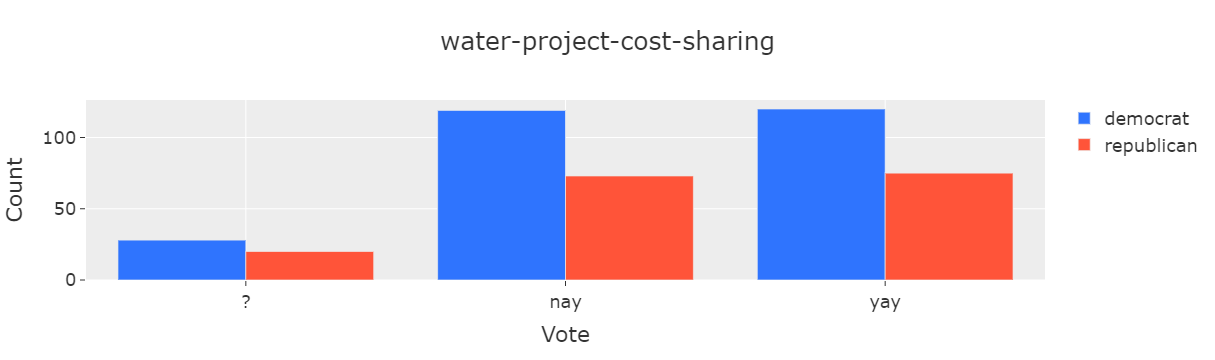

In [101]:
plot_bar('water-project-cost-sharing')

For the *water-project-cost-sharing* measure, both parties had a majority yay vote but only by a tiny margin. This results in roughly half of the party voting against the party majority and is why the measure has a value of 1 for democrats in the figure above. It should be obvious why this ballot measure is not a good predictor of the party since the parties themselves are split 50/50 between yays and nays, and the two parties have an almost identical distribution of votes so there is nothing that distinguishes them from each other. Whether we predict the class to be democrat or republican based on the values yay or nay in this measure, we have a 50/50 chance of being right or wrong. This is why I decided to look at divisive measures only as I defined them above. 

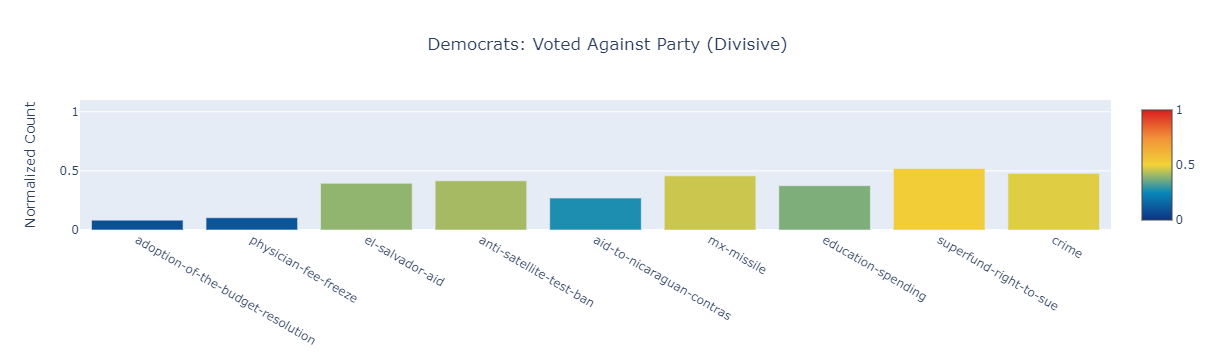

In [102]:
plot_votes(df=df1[divisive_cols], title='Democrats: Voted Against Party (Divisive)')

The plot above is the same distribution of votes against the majority as before but subset to only divisive measures. This is distribution of votes against the majority for democrats classified correctly. Below, we'll compare this distribution to the distribution of the misclassified samples.

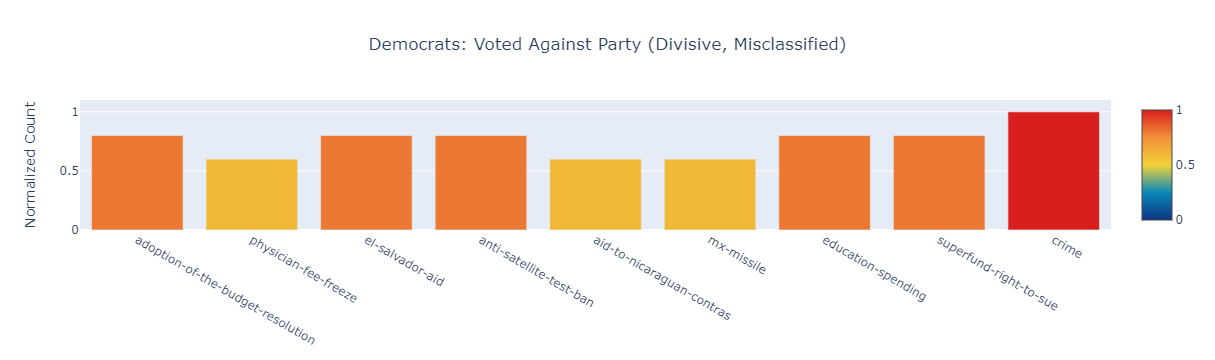

In [103]:
df2 = mis_against_majority_dem_divisive.sum()/mis_against_majority_dem.sum().max()

plot_votes(df=df2, title='Democrats: Voted Against Party (Divisive, Misclassified)')

# Think about how you're normalizing these distributions and if there's a more appropriate way to normalize.

In [ ]:
diff = mis_voted_against_dem_divisive.sum()/mis_voted_against_dem.sum().max() - voted_against_dem_divisive.sum()/voted_against_dem.sum().max()
plot_votes(data=diff, title='Voted Against Party (Divisive) Difference (Misclassified - Correct)')

In [ ]:
data = voted_against_rep_divisive.sum()/voted_against_rep_divisive.sum().max()
plot_votes(data=data, title='Republicans: Voted Against Party (Divisive)')

In [ ]:
data = mis_voted_against_rep_divisive.sum()/mis_voted_against_rep_divisive.sum().max()
plot_votes(data=data, title='Republicans: Voted Against Party (Divisive, Misclassified)')

In [ ]:
['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd']

### KNN with Mean Imputation

In [ ]:
# Create our imputer to replace missing values with the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

X_train_imp_mean = imp.transform(X_train)

In [ ]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train_imp_mean, y_train)

# predict the response
pred = knn.predict(imp.transform(X_test))

# evaluate accuracy
print("accuracy: {}".format(round(accuracy_score(y_test, pred), 4)))